In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Here the new dataset is results taken from my All ODP Images file in which I saved all the results in Image directory file instead of other folder , and csv file is file that contains information as data frame

In [2]:
# Define the path to the CSV file
csv_file_path = 'new_dataset/new_filtered_images.csv'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Display the first few rows of the dataframe
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,preprocessed_images/H-Flip_13_right.jpg,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_13_right.jpg
1,16,54,Female,16_left.jpg,16_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,preprocessed_images/H-Flip_16_right.jpg,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_16_right.jpg
2,18,58,Male,18_left.jpg,18_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,preprocessed_images/H-Flip_18_right.jpg,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_18_right.jpg
3,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,preprocessed_images/H-Flip_24_right.jpg,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",H-Flip_24_right.jpg
4,43,35,Male,43_left.jpg,43_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0,preprocessed_images/H-Flip_43_right.jpg,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",H-Flip_43_right.jpg


   ID  Patient Age Patient Sex  Left-Fundus  Right-Fundus  \
0  13           60      Female  13_left.jpg  13_right.jpg   
1  16           54      Female  16_left.jpg  16_right.jpg   
2  18           58        Male  18_left.jpg  18_right.jpg   
3  24           75      Female  24_left.jpg  24_right.jpg   
4  43           35        Male  43_left.jpg  43_right.jpg   

               Left-Diagnostic Keywords  \
0                   pathological myopia   
1                         normal fundus   
2                   pathological myopia   
3                         normal fundus   
4  wet age-related macular degeneration   

                       Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                            pathological myopia  0  0  0  0  0  0  1  0   
1                            pathological myopia  0  0  0  0  0  0  1  0   
2                            pathological myopia  0  0  0  0  0  0  1  0   
3                                       cataract  0  0  0  1  0  0  0 

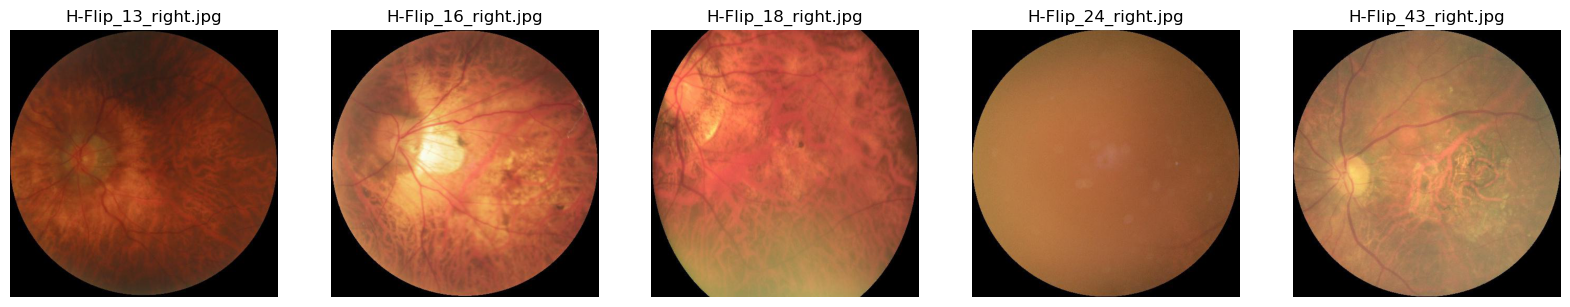

In [1]:
# Define the path to the CSV file
csv_file_path = 'new_dataset/new_filtered_images.csv'
image_directory = 'new_dataset/'  # Directory where images are stored

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Update the file paths
df['filepath'] = df['filepath'].apply(lambda x: os.path.join(image_directory, x))

# Display the first few rows of the dataframe
print(df.head())

# Function to display images
def display_images(image_paths, titles=None):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 5))
    if len(image_paths) == 1:
        axes = [axes]
    for i, image_path in enumerate(image_paths):
        if os.path.exists(image_path):
            img = mpimg.imread(image_path)
            axes[i].imshow(img)
            if titles is not None:
                axes[i].set_title(titles[i])
        else:
            axes[i].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].axis('off')
    plt.show()

# Select a few image paths to verify
image_paths = df['filepath'].head(5).tolist()
titles = df['filename'].head(5).tolist()

# Display the images
display_images(image_paths, titles)



In [4]:
def contains_keyword(keyword, phrase):
    # Return 1 if the keyword is in the phrase, otherwise return 0
    return 1 if keyword in phrase else 0

def check_condition(keywords, condition):
    # Check if a specific condition is present in the diagnostic keywords
    return keywords.apply(lambda x: contains_keyword(condition, x))

def extract_image_ids(data, condition_flag, eye, label, sample_size=None):
    # Extract image IDs based on the condition and label
    if sample_size:
        return data.loc[(data.C == label) & (data[f"{eye}-Diagnostic Keywords"] == condition_flag)][f'{eye}-Fundus'].sample(sample_size, random_state=42).values
    return data.loc[(data.C == label) & (condition_flag == 1)][f'{eye}-Fundus'].values

def merge_images(*arrays):
    # Concatenate multiple arrays of image IDs
    return np.concatenate(arrays, axis=0)

def process_dataset(data):
    # Define conditions and corresponding column names
    conditions = [
        ("cataract", "left_cataract", "right_cataract"),
        ("non proliferative retinopathy", "left_npr", "right_npr"),
        ("glaucoma", "left_glaucoma", "right_glaucoma"),
        ("myopia", "left_myopia", "right_myopia"),
        ("macular degeneration", "left_md", "right_md"),
        ("drusen", "left_drusen", "right_drusen")
    ]

    # Create columns to indicate the presence of each condition in the left and right eyes
    for cond, left_col, right_col in conditions:
        data[left_col] = check_condition(data[f"Left-Diagnostic Keywords"], cond)
        data[right_col] = check_condition(data[f"Right-Diagnostic Keywords"], cond)

    # Extract image IDs for various conditions
    left_cataract_ids = extract_image_ids(data, data.left_cataract, "Left", 1)
    right_cataract_ids = extract_image_ids(data, data.right_cataract, "Right", 1)

    left_normal_ids = extract_image_ids(data, "normal fundus", "Left", 0, sample_size=750)
    right_normal_ids = extract_image_ids(data, "normal fundus", "Right", 0, sample_size=750)

    left_diabetes_ids = extract_image_ids(data, data.left_npr, "Left", 0)
    right_diabetes_ids = extract_image_ids(data, data.right_npr, "Right", 0)

    left_glaucoma_ids = extract_image_ids(data, data.left_glaucoma, "Left", 0)
    right_glaucoma_ids = extract_image_ids(data, data.right_glaucoma, "Right", 0)

    left_myopia_ids = extract_image_ids(data, data.left_myopia, "Left", 0)
    right_myopia_ids = extract_image_ids(data, data.right_myopia, "Right", 0)

    left_md_ids = extract_image_ids(data, data.left_md, "Left", 0)
    right_md_ids = extract_image_ids(data, data.right_md, "Right", 0)

    left_drusen_ids = extract_image_ids(data, data.left_drusen, "Left", 0)
    right_drusen_ids = extract_image_ids(data, data.right_drusen, "Right", 0)

    # Concatenate image IDs for the left and right eyes for each condition
    normal_images = merge_images(left_normal_ids, right_normal_ids)
    cataract_images = merge_images(left_cataract_ids, right_cataract_ids)
    diabetes_images = merge_images(left_diabetes_ids, right_diabetes_ids)
    glaucoma_images = merge_images(left_glaucoma_ids, right_glaucoma_ids)
    myopia_images = merge_images(left_myopia_ids, right_myopia_ids)
    md_images = merge_images(left_md_ids, right_md_ids)
    drusen_images = merge_images(left_drusen_ids, right_drusen_ids)

    return normal_images, cataract_images, diabetes_images, glaucoma_images, myopia_images, md_images, drusen_images


In [5]:
# Process the dataset to get lists of image IDs for different conditions
normal_images, cataract_images, diabetes_images, glaucoma_images, myopia_images, md_images, drusen_images = process_dataset(df)

# Print the dataset statistics
print("Dataset Statistics:")
print("Normal ::", len(normal_images))        
print("Cataract ::", len(cataract_images))    
print("Diabetes ::", len(diabetes_images))    
print("Glaucoma ::", len(glaucoma_images))    
print("Myopia ::", len(myopia_images))        
print("Macular Degeneration ::", len(md_images))  
print("Drusen ::", len(drusen_images))        


Dataset Statistics:
Normal :: 1500
Cataract :: 2032
Diabetes :: 1962
Glaucoma :: 2158
Myopia :: 1738
Macular Degeneration :: 2022
Drusen :: 591


In [6]:
# Define the directory path where images are stored
image_dir = 'New_dataset/preprocessed_images'
image_size = 224

def generate_dataset(image_list, label):
    """
    Generate a dataset of images and labels.

    Parameters:
    image_list (list): List of image filenames.
    label (int): Label corresponding to the images.

    Returns:
    list: List of tuples where each tuple contains an image array and its label.
    """
    dataset = []
    for image_file in image_list:
        img_path = os.path.join(image_dir, image_file)
        
        # Load the image using OpenCV
        try:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            # Resize the image to the desired size
            img = cv2.resize(img, (image_size, image_size))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue
        
        # Append the image array and its label to the dataset
        dataset.append([np.array(img), np.array(label)])
    
    # Shuffle the dataset to ensure random order
    random.shuffle(dataset)
    
    return dataset

# Initialize the combined dataset
combined_dataset = []

# Process each category of images and append to the combined dataset
print("Generating datasets for each category...")

normal_dataset = generate_dataset(normal_images, 0)
combined_dataset += normal_dataset

cataract_dataset = generate_dataset(cataract_images, 1)
combined_dataset += cataract_dataset

diabetes_dataset = generate_dataset(diabetes_images, 2)
combined_dataset += diabetes_dataset

glaucoma_dataset = generate_dataset(glaucoma_images, 3)
combined_dataset += glaucoma_dataset

myopia_dataset = generate_dataset(myopia_images, 4)
combined_dataset += myopia_dataset

macular_degeneration_dataset = generate_dataset(md_images, 5)
combined_dataset += macular_degeneration_dataset

drusen_dataset = generate_dataset(drusen_images, 6)
combined_dataset += drusen_dataset

# Print the total number of images in the combined dataset
print("Total number of images in the combined dataset:", len(combined_dataset))


Generating datasets for each category...
Error loading image New_dataset/preprocessed_images\2102_left.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error loading image New_dataset/preprocessed_images\2231_left.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error loading image New_dataset/preprocessed_images\2244_left.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error loading image New_dataset/preprocessed_images\2251_left.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error loading image New_dataset/pre

In [7]:
# Define image size
image_size = 224

# Convert the combined dataset into predictors (images) and targets (labels)
predictor_images = np.array([item[0] for item in combined_dataset]).reshape(-1, image_size, image_size, 3)
target_labels = np.array([item[1] for item in combined_dataset])

# Split the dataset into training, temporary (testing + validation), and then into testing and validation sets
x_train, x_temp, y_train, y_temp = train_test_split(predictor_images, target_labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Convert target labels to categorical format
y_train_categorical = to_categorical(y_train, num_classes=7)
y_val_categorical = to_categorical(y_val, num_classes=7)
y_test_categorical = to_categorical(y_test, num_classes=7)

# Print the shapes of the datasets to verify the splits
print(f"x_train shape: {x_train.shape}, y_train_categorical shape: {y_train_categorical.shape}")
print(f"x_val shape: {x_val.shape}, y_val_categorical shape: {y_val_categorical.shape}")
print(f"x_test shape: {x_test.shape}, y_test_categorical shape: {y_test_categorical.shape}")


x_train shape: (8333, 224, 224, 3), y_train_categorical shape: (8333, 7)
x_val shape: (1786, 224, 224, 3), y_val_categorical shape: (1786, 7)
x_test shape: (1786, 224, 224, 3), y_test_categorical shape: (1786, 7)


Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 756s 3s/step - accuracy: 0.1887 - loss: 32.0065 - val_accuracy: 0.3085 - val_loss: 1.8145
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 690s 3s/step - accuracy: 0.2704 - loss: 1.7975 - val_accuracy: 0.3264 - val_loss: 1.7033
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 657s 3s/step - accuracy: 0.3330 - loss: 1.6985 - val_accuracy: 0.3835 - val_loss: 1.6015
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 746s 3s/step - accuracy: 0.3686 - loss: 1.6167 - val_accuracy: 0.3931 - val_loss: 1.5382
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - accuracy: 0.4129 - loss: 1.5234 - val_accuracy: 0.4602 - val_loss: 1.4335
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.4575 - loss: 1.4018 - val_accuracy: 0.5090 - val_loss: 1.3251
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.4990 - loss: 1.3040 - val_accuracy: 0.5644 - val_loss: 1.2257
Epoch 8/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.5603 - loss: 1.1611 - val_acc

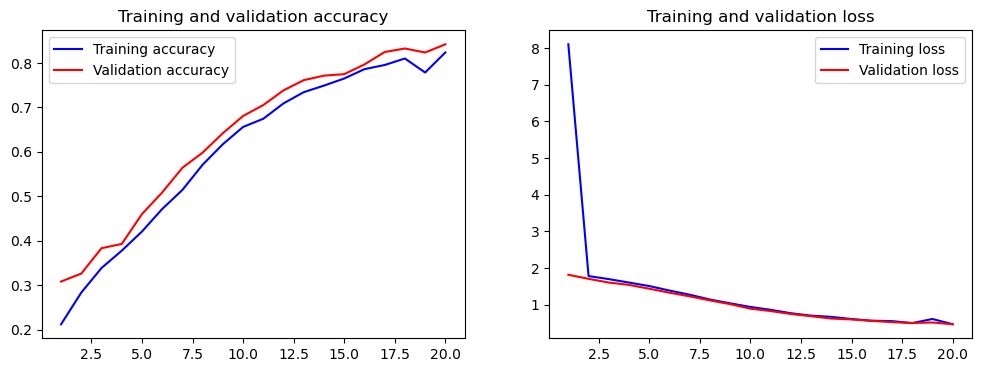

56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 556ms/step - accuracy: 0.8100 - loss: 0.4880
Test accuracy: 0.8185890316963196
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 565ms/step
                      precision    recall  f1-score   support

              Normal       0.77      0.37      0.50       230
            Cataract       0.92      0.94      0.93       287
            Diabetes       0.61      0.77      0.68       297
            Glaucoma       0.89      0.91      0.90       311
              Myopia       0.91      0.96      0.93       270
Macular Degeneration       0.83      0.94      0.88       302
              Drusen       0.89      0.57      0.70        89

            accuracy                           0.82      1786
           macro avg       0.83      0.78      0.79      1786
        weighted avg       0.82      0.82      0.81      1786



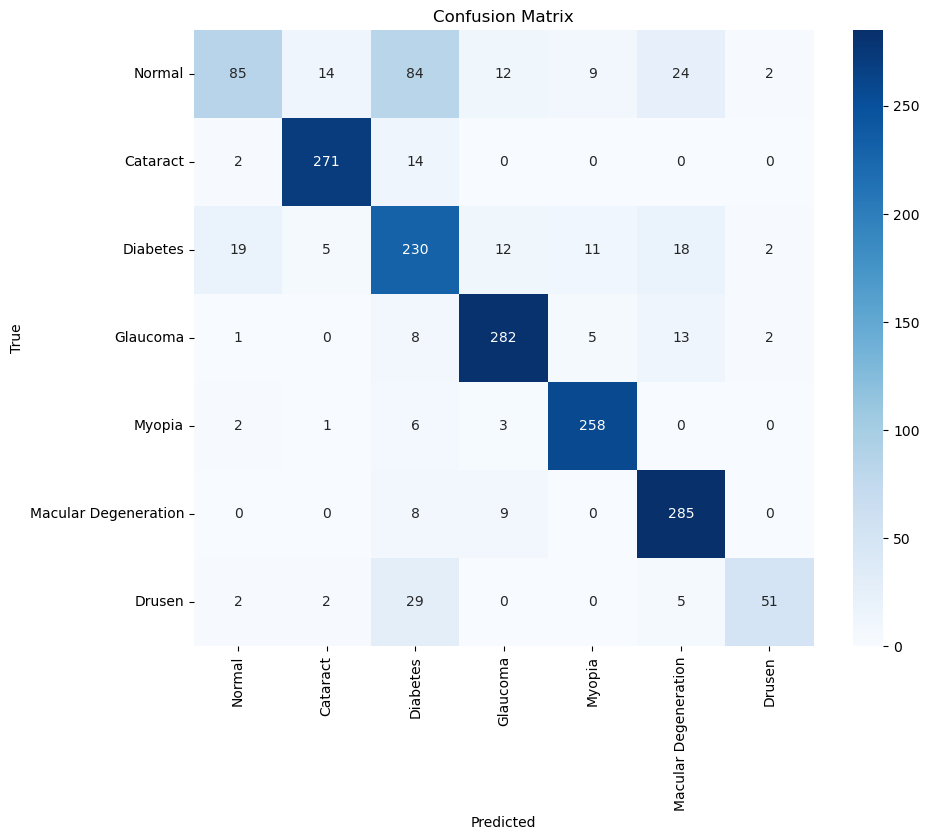

In [9]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
input_shape = (image_size, image_size, 3)
num_classes = 7
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train, y_train_categorical,
    epochs=20,
    validation_data=(x_val, y_val_categorical)
)

# Plot training and validation accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test_categorical)
print(f'Test accuracy: {test_accuracy}')

# Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Generate classification report
class_names = ['Normal', 'Cataract', 'Diabetes', 'Glaucoma', 'Myopia', 'Macular Degeneration', 'Drusen']
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Generate classification report
class_names = ['N', 'C', 'D', 'G', 'M', 'A', 'O']
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()